In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import KFold
%matplotlib inline

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [6]:
try:
    train_df = pd.read_csv('train_data.csv')
    val_df = pd.read_csv('val_data.csv')
    test_df = pd.read_csv('test_data.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure 'train_data.csv', 'val_data.csv', and 'test_data.csv' are in {os.getcwd()}")
    raise

train_df = train_df.fillna(0)
val_df = val_df.fillna(0)
test_df = test_df.fillna(0)

combined_df = pd.concat([train_df, val_df], ignore_index=True)

try:
    y_combined = combined_df['RemainingLaps']
    X_combined_flat = combined_df.drop('RemainingLaps', axis=1)
    y_test = test_df['RemainingLaps']
    X_test_flat = test_df.drop('RemainingLaps', axis=1)
except KeyError as e:
    print(f"Error: {e}. Ensure 'RemainingLaps' column exists in all CSV files. Columns found in train_data.csv: {train_df.columns.tolist()}")
    raise


In [7]:
try:
    y_combined = combined_df['RemainingLaps']
    X_combined_flat = combined_df.drop('RemainingLaps', axis=1)
    y_test = test_df['RemainingLaps']
    X_test_flat = test_df.drop('RemainingLaps', axis=1)
except KeyError as e:
    print(f"Error: {e}. Ensure 'RemainingLaps' column exists in all CSV files. Columns found in train_data.csv: {train_df.columns.tolist()}")
    raise

In [8]:
window_size = 2

# Calculate number of features per timestep
try:
    N = X_combined_flat.shape[1] // window_size
    assert X_combined_flat.shape[1] % window_size == 0, f"Number of feature columns ({X_combined_flat.shape[1]}) must be divisible by window_size ({window_size})"
except AssertionError as e:
    print(f"Error: {e}. Check feature columns in CSV files.")
    raise

In [9]:
# Reshape flattened features into 3D arrays (samples, timesteps, features)
X_combined = X_combined_flat.values.reshape(-1, window_size, N)
X_test = X_test_flat.values.reshape(-1, window_size, N)

# Convert to PyTorch tensors
X_combined = torch.tensor(X_combined, dtype=torch.float32).to(device)
y_combined = torch.tensor(y_combined.values, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Verify no NaN values
assert not torch.isnan(X_combined).any(), "NaN values detected in X_combined after filling"
assert not torch.isnan(y_combined).any(), "NaN values detected in y_combined after filling"
assert not torch.isnan(X_test).any(), "NaN values detected in X_test after filling"
assert not torch.isnan(y_test).any(), "NaN values detected in y_test after filling"

In [10]:
def r2_score(y_true, y_pred):
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2.item()

In [11]:
class TireStintLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TireStintLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.4)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.4)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout3 = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out, _ = self.lstm3(out)
        out = self.dropout3(out[:, -1, :])
        out = self.fc(out)
        return out

In [12]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_train_losses = []
cv_val_losses = []
cv_train_r2_scores = []
cv_val_r2_scores = []

In [13]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_combined)):
    print(f"\nTraining Fold {fold + 1}/{n_splits}")
    
    # Split data into training and validation for this fold
    X_train_fold = X_combined[train_idx]
    y_train_fold = y_combined[train_idx]
    X_val_fold = X_combined[val_idx]
    y_val_fold = y_combined[val_idx]
    
    # Instantiate model
    model = TireStintLSTM(input_size=N, hidden_size=128).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    train_r2_scores = []
    val_r2_scores = []
    patience = 5
    patience_counter = 0
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_fold)
        loss = criterion(outputs.squeeze(), y_train_fold)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Compute training R²
        with torch.no_grad():
            train_r2 = r2_score(y_train_fold, outputs.squeeze())
            train_r2_scores.append(train_r2)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_fold)
            val_loss = criterion(val_outputs.squeeze(), y_val_fold)
            val_losses.append(val_loss.item())
            val_r2 = r2_score(y_val_fold, val_outputs.squeeze())
            val_r2_scores.append(val_r2)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        if epoch % 10 == 0:  # Print every 10 epochs to reduce output
            print(f"Fold {fold + 1}, Epoch {epoch+1}/100, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")
    
    # Store metrics for this fold
    cv_train_losses.append(train_losses[-1])
    cv_val_losses.append(val_losses[-1])
    cv_train_r2_scores.append(train_r2_scores[-1])
    cv_val_r2_scores.append(val_r2_scores[-1])


Training Fold 1/5
Fold 1, Epoch 1/100, Train Loss: 248.6424, Val Loss: 251.2422, Train R²: -1.5278, Val R²: -1.5391
Fold 1, Epoch 11/100, Train Loss: 242.7002, Val Loss: 244.5383, Train R²: -1.4674, Val R²: -1.4713
Fold 1, Epoch 21/100, Train Loss: 214.8168, Val Loss: 211.3083, Train R²: -1.1839, Val R²: -1.1355
Fold 1, Epoch 31/100, Train Loss: 143.1059, Val Loss: 137.5048, Train R²: -0.4549, Val R²: -0.3896
Fold 1, Epoch 41/100, Train Loss: 104.5178, Val Loss: 103.5637, Train R²: -0.0626, Val R²: -0.0466
Fold 1, Epoch 51/100, Train Loss: 93.7071, Val Loss: 93.0973, Train R²: 0.0473, Val R²: 0.0592
Fold 1, Epoch 61/100, Train Loss: 86.0061, Val Loss: 84.9251, Train R²: 0.1256, Val R²: 0.1417
Fold 1, Epoch 71/100, Train Loss: 78.9435, Val Loss: 77.4540, Train R²: 0.1974, Val R²: 0.2173
Fold 1, Epoch 81/100, Train Loss: 72.2057, Val Loss: 70.5947, Train R²: 0.2659, Val R²: 0.2866
Fold 1, Epoch 91/100, Train Loss: 64.9152, Val Loss: 62.7624, Train R²: 0.3400, Val R²: 0.3657

Training Fo

In [14]:
print("\nCross-Validation Results:")
print(f"Average Train Loss: {np.mean(cv_train_losses):.4f} ± {np.std(cv_train_losses):.4f}")
print(f"Average Val Loss: {np.mean(cv_val_losses):.4f} ± {np.std(cv_val_losses):.4f}")
print(f"Average Train R²: {np.mean(cv_train_r2_scores):.4f} ± {np.std(cv_train_r2_scores):.4f}")
print(f"Average Val R²: {np.mean(cv_val_r2_scores):.4f} ± {np.std(cv_val_r2_scores):.4f}")

## Train Final Model on Full Training Data
# Instantiate model
model = TireStintLSTM(input_size=N, hidden_size=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)



Cross-Validation Results:
Average Train Loss: 55.1620 ± 1.5119
Average Val Loss: 53.1855 ± 1.5816
Average Train R²: 0.4399 ± 0.0157
Average Val R²: 0.4600 ± 0.0139


In [15]:
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
patience = 5
patience_counter = 0
best_val_loss = float('inf')
best_model_state = None

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_combined)
    loss = criterion(outputs.squeeze(), y_combined)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Compute training R²
    with torch.no_grad():
        train_r2 = r2_score(y_combined, outputs.squeeze())
        train_r2_scores.append(train_r2)
    
    # Validation (using val_data.csv for consistency)
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs.squeeze(), y_val)
        val_losses.append(val_loss.item())
        val_r2 = r2_score(y_val, val_outputs.squeeze())
        val_r2_scores.append(val_r2)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} for final model")
            break
    
    if epoch % 10 == 0:
        print(f"Final Model, Epoch {epoch+1}/100, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

## Evaluation
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs.squeeze(), y_test)
    test_r2 = r2_score(y_test, test_outputs.squeeze())
print(f"\nFinal Model Test Results:")
print(f"Test Loss (MSE): {test_loss.item():.4f}")
print(f"Test R²: {test_r2:.4f}")


NameError: name 'X_val' is not defined

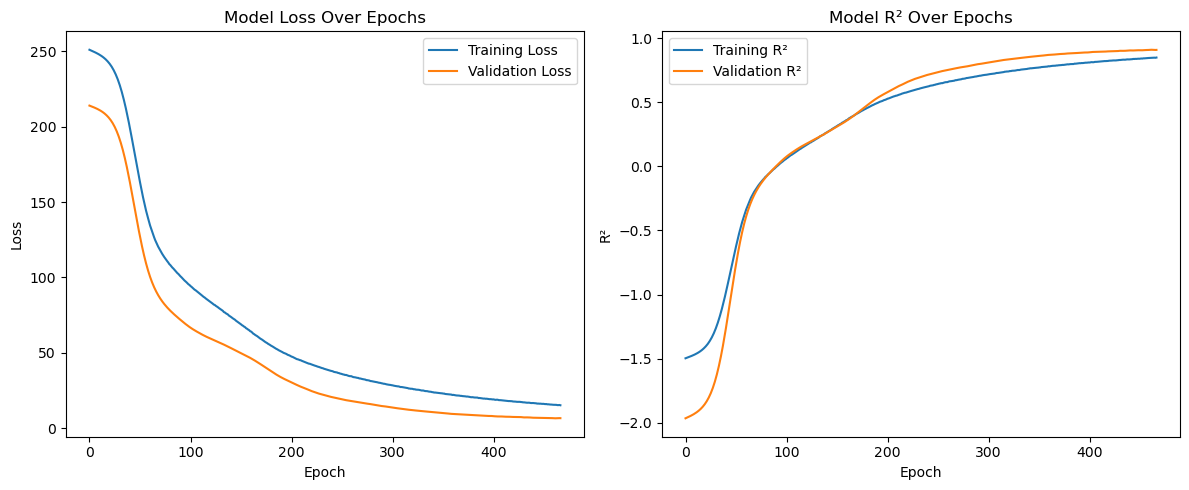

In [48]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation R²
plt.subplot(1, 2, 2)
plt.plot(train_r2_scores, label='Training R²')
plt.plot(val_r2_scores, label='Validation R²')
plt.title('Model R² Over Epochs')
plt.ylabel('R²')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
torch.save(model.state_dict(), 'tire_stint_model_pytorch.pth')
print("Model saved as 'tire_stint_model_pytorch.pth'")

Model saved as 'tire_stint_model_pytorch.pth'
